In [1]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential , load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  0
2.19.0


(<Axes: >, <matplotlib.image.AxesImage at 0x2425e333310>)

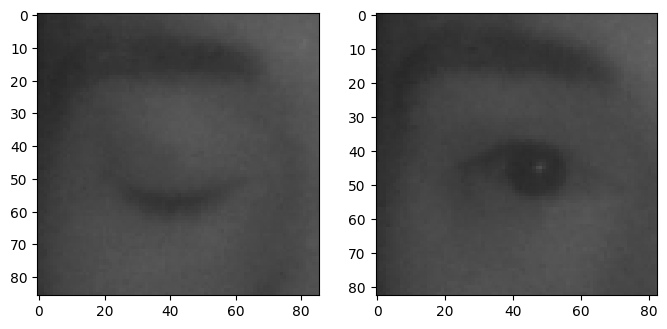

In [4]:
#arindamxd,dhirdevansh,kutaykutlu
img1 = cv2.imread('Data/train/closed/_1.png')
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)

img2 = cv2.imread('Data/train/open/_1.png')
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)

In [18]:
width = 128
num_classes = 2
trainpath = 'Data/train/'
testpath = 'Data/test/'
testExPath = 'img/Test/'
trainImg = [trainpath+f for f in listdir(trainpath)]
testImg = [testpath+f for f in listdir(testpath)]
testExImg = [testExPath + f for f in listdir(testExPath)]
img_size = 128
batch_size = 32

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    trainpath,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 82934 images belonging to 2 classes.


In [20]:
trainImg , testImg ,testExImg

(['Data/train/Closed', 'Data/train/Open'],
 ['Data/test/Closed', 'Data/test/Open'],
 ['img/Test/Closed', 'img/Test/Open'])

In [8]:
def img2data(path):
    rawImgs = []
    labels = []

    for imagePath in (path):
        print(imagePath)
        for item in tqdm(listdir(imagePath)):
            file = join(imagePath, item)
            if file[-1] =='g':
                img = cv2.imread(file , cv2.COLOR_BGR2RGB)
                img = cv2.resize(img ,(width,width))
                rawImgs.append(img)
            
                l = imagePath.split('/')[-1]
                if l == 'Closed':
                    labels.append([1,0])         
                elif l == 'Open':
                    labels.append([0,1])
            
    return rawImgs, labels

In [10]:
x_train, y_train = img2data(trainImg)
x_test, y_test = img2data(testImg)
x_test_ex , y_test_ex = img2data(testExImg)

Data/train/Closed


100%|██████████| 45040/45040 [00:15<00:00, 2840.58it/s]


Data/train/Open


100%|██████████| 37894/37894 [01:03<00:00, 594.88it/s] 


Data/test/Closed


100%|██████████| 403/403 [00:01<00:00, 325.23it/s]


Data/test/Open


100%|██████████| 546/546 [00:00<00:00, 807.70it/s]


img/Test/Closed


100%|██████████| 110/110 [00:00<00:00, 1472.84it/s]


img/Test/Open


100%|██████████| 892/892 [00:00<00:00, 1917.04it/s]


In [11]:
x_train = np.array([cv2.resize(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), (img_size, img_size)) for image in x_train])
y_train = np.array(y_train)
x_test = np.array([cv2.resize(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), (img_size, img_size)) for image in x_test])
y_test = np.array(y_test)
x_test_ex = np.array([cv2.resize(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), (img_size, img_size)) for image in x_test_ex])
y_test_ex = np.array(y_test_ex)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_ex = x_test_ex.astype('float32')
x_train /= 255
x_test /= 255
x_test_ex /= 255

In [12]:
x_test.shape, y_test.shape,x_test_ex.shape,y_test_ex.shape,x_train.shape, y_train.shape

((949, 128, 128, 3),
 (949, 2),
 (1002, 128, 128, 3),
 (1002, 2),
 (82934, 128, 128, 3),
 (82934, 2))

In [13]:
# base_model = load_model('CNNModel.keras')
base_model = MobileNetV2(input_shape=(img_size,img_size,3),include_top= False,weights='imagenet')
# model = load_model('MobileNetV2Model.keras')
MobileNetMOdel = load_model('CNNNewModel0_3.keras')
CNNModel = load_model('MobileNetV1Model0_3.keras')

for layer in MobileNetMOdel.layers[:-1]:
    layer.trainable = False

MobileNetMOdel.layers[-1].trainable = True

for layer in CNNModel.layers[:-1]:
    layer.trainable = False

CNNModel.layers[-1].trainable = True

In [14]:

CNNModel.summary()
MobileNetMOdel.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 2, 2, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1, 1, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,741,320 (14.27 MB)

 Trainable params: 130 (520.00 B)

 Non-trainable params: 3,740,928 (14.27 MB)

 Optimizer params: 262 (1.03 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │       200,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,784 (1.62 MB)

 Trainable params: 34 (136.00 B)

 Non-trainable params: 425,680 (1.62 MB)

 Optimizer params: 70 (284.00 B)

In [21]:
epochs = 30
MobileNetMOdel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
CNNModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
historyMobile = MobileNetMOdel.fit(train_generator, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop])
historyCNN = CNNModel.fit(train_generator, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop])

c:\Users\atich\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 111/2592 ━━━━━━━━━━━━━━━━━━━━ 7:13 175ms/step - accuracy: 0.7482 - loss: 0.5403

KeyboardInterrupt: 

In [ ]:
historyMobileNet = MobileNetMOdel.fit(
    x_train, y_train 
    ,batch_size=16
    , epochs=epochs 
    ,validation_data=(x_test, y_test)
    ,callbacks=[early_stop]
)
historyCNNModel =CNNModel.fit(
    x_train, y_train 
    ,batch_size=16
    , epochs=epochs 
    ,validation_data=(x_test, y_test)
    ,callbacks=[early_stop]
)

Epoch 1/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 435s 84ms/step - accuracy: 0.9285 - loss: 0.2400 - val_accuracy: 0.9905 - val_loss: 0.0294
Epoch 2/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 383s 75ms/step - accuracy: 0.9339 - loss: 0.1934 - val_accuracy: 0.9768 - val_loss: 0.0807
Epoch 3/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 381s 75ms/step - accuracy: 0.9347 - loss: 0.1894 - val_accuracy: 0.9926 - val_loss: 0.0285
Epoch 4/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 382s 75ms/step - accuracy: 0.9335 - loss: 0.1905 - val_accuracy: 0.9937 - val_loss: 0.0225
Epoch 5/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 366s 72ms/step - accuracy: 0.9318 - loss: 0.1944 - val_accuracy: 0.9947 - val_loss: 0.0176
Epoch 6/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 372s 73ms/step - accuracy: 0.9350 - loss: 0.1896 - val_accuracy: 0.9315 - val_loss: 0.3555
Epoch 7/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 358s 70ms/step - accuracy: 0.9338 - loss: 0.1905 - val_accuracy: 0.9473 - val_loss: 0.2033
Epoch 8/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 352s 69ms/step - accuracy: 

In [ ]:
# historyModel = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))
historyCNNModel =CNNModel.fit(
    x_train, y_train 
    ,batch_size=16
    , epochs=epochs 
    ,validation_data=(x_test, y_test)
    ,callbacks=[early_stop]
)
# historyMobileNet = MobileNetMOdel.fit(
#     x_train, y_train 
#     ,batch_size=32
#     , epochs=epochs 
#     ,validation_data=(x_test, y_test)
#     ,callbacks=[early_stop])

Epoch 1/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 435s 61ms/step - accuracy: 0.9721 - loss: 0.0912 - val_accuracy: 0.9694 - val_loss: 0.1092
Epoch 2/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 427s 61ms/step - accuracy: 0.9717 - loss: 0.0933 - val_accuracy: 0.9684 - val_loss: 0.1015
Epoch 3/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 433s 61ms/step - accuracy: 0.9721 - loss: 0.0942 - val_accuracy: 0.9694 - val_loss: 0.1033
Epoch 4/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 447s 63ms/step - accuracy: 0.9723 - loss: 0.0915 - val_accuracy: 0.9684 - val_loss: 0.1061
Epoch 5/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 442s 63ms/step - accuracy: 0.9717 - loss: 0.0927 - val_accuracy: 0.9684 - val_loss: 0.1028
Epoch 6/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 447s 63ms/step - accuracy: 0.9711 - loss: 0.0943 - val_accuracy: 0.9694 - val_loss: 0.1083
Epoch 7/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 453s 64ms/step - accuracy: 0.9721 - loss: 0.0928 - val_accuracy: 0.9684 - val_loss: 0.1035
Epoch 8/100
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 463s 66ms/step - ac

In [ ]:
# history = model.fit(x_train, y_train ,batch_size=batch_size, epochs=epochs ,validation_data=(x_test, y_test))

In [ ]:
MobileNetMOdel.save('MobileNetV1Model0_3.keras')
CNNModel.save('CNNNewModel0_3.keras')

NameError: name 'historyMobileNet' is not defined

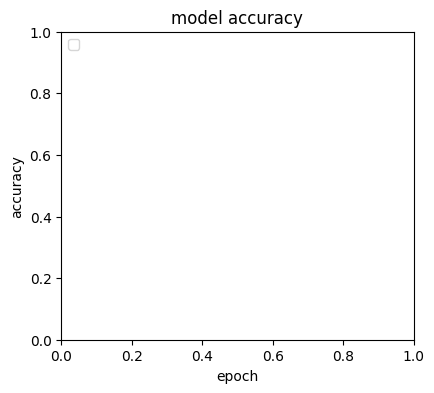

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(historyMobileNet.history['accuracy']);plt.plot(historyMobileNet.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(historyMobileNet.history['loss']);plt.plot(historyMobileNet.history['val_loss'])

NameError: name 'historyModel' is not defined

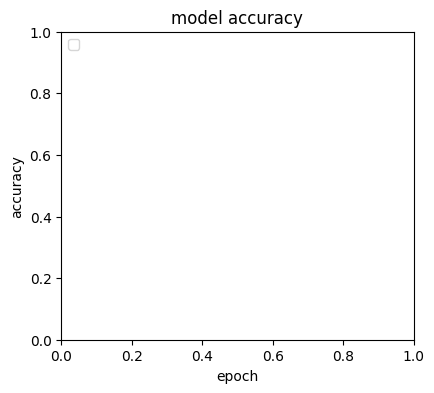

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(historyModel.history['accuracy']);plt.plot(historyModel.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(historyModel.history['loss']);plt.plot(historyModel.history['val_loss'])

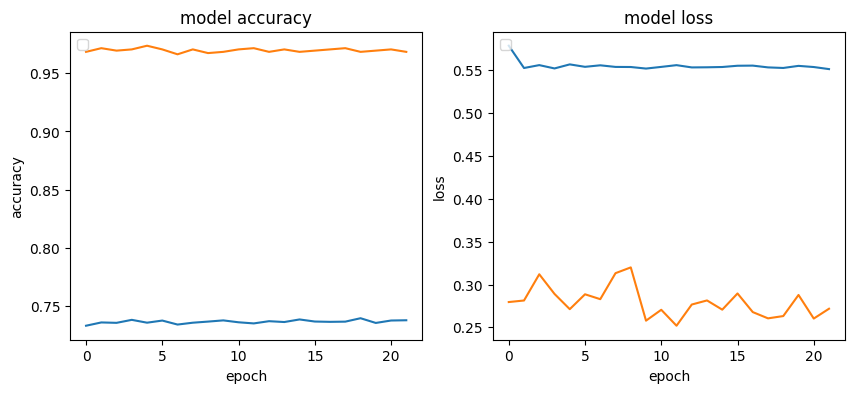

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(121),
plt.title('model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['accuracy']);plt.plot(history.history['val_accuracy'])

plt.subplot(122)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot(history.history['loss']);plt.plot(history.history['val_loss'])

In [ ]:
testpath = ''
testImg = [testpath+f for f in listdir(testpath)]
count = 0
for imagePath in (testImg):
    for i,item in enumerate(listdir(imagePath)):
        file = join(imagePath, item)
        print(file)
        count +=1

print(count)

Data/test/Closed
0
Data/test/Closed\ex_img_0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1
Data/test/Closed\ex_img_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2
Data/test/Closed\ex_img_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3
Data/test/Closed\ex_img_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4
Data/test/Closed\ex_img_12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5
Data/test/Closed\ex_img_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6
Data/test/Closed\ex_img_1319.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7
Data/test/Closed\ex_img_1320.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8
Data/test/Closed\ex_img_1321.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

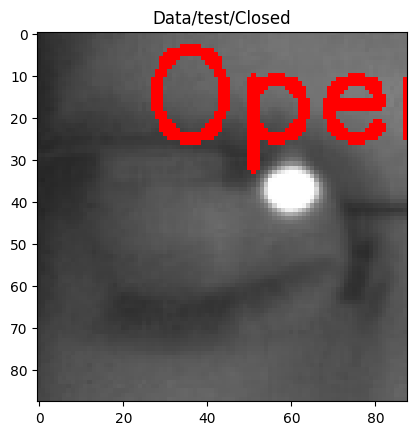

50
Data/test/Closed\ex_img_1363.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
51
Data/test/Closed\ex_img_1364.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
52
Data/test/Closed\ex_img_1365.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
53
Data/test/Closed\ex_img_1366.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
54
Data/test/Closed\ex_img_1367.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
55
Data/test/Closed\ex_img_1368.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
56
Data/test/Closed\ex_img_1369.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
57
Data/test/Closed\ex_img_1370.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
58
Data/test/Closed\ex_img_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms

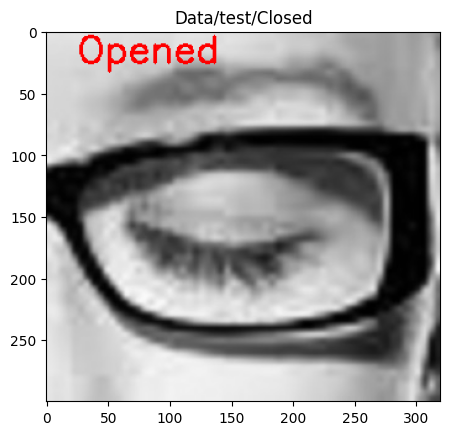

213
Data/test/Closed\_244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
214
Data/test/Closed\_245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
215
Data/test/Closed\_246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
216
Data/test/Closed\_247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
217
Data/test/Closed\_248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
218
Data/test/Closed\_249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
219
Data/test/Closed\_25.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
220
Data/test/Closed\_250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
221
Data/test/Closed\_251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
222
Data/test/Closed\_252.jpg
1/1 ━━━━━━━━━━━━━

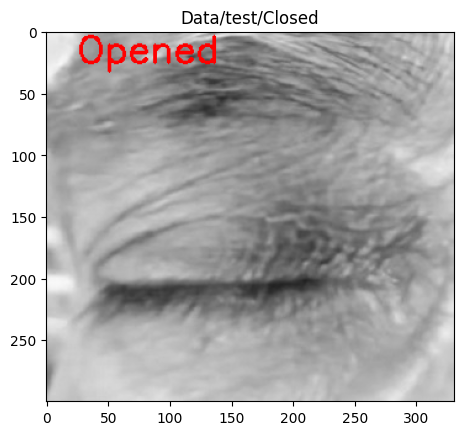

284
Data/test/Closed\_315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
285
Data/test/Closed\_316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
286
Data/test/Closed\_317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
287
Data/test/Closed\_318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
288
Data/test/Closed\_319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
289
Data/test/Closed\_32.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
290
Data/test/Closed\_320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
291
Data/test/Closed\_321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
292
Data/test/Closed\_322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predict Mobile : [[0.40575558 0.59424436]]  :  

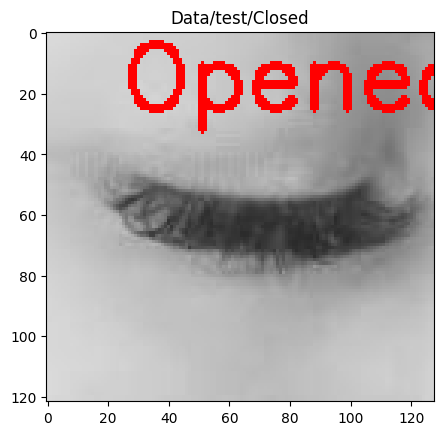

293
Data/test/Closed\_323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
294
Data/test/Closed\_324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
295
Data/test/Closed\_325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
296
Data/test/Closed\_327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
297
Data/test/Closed\_328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
298
Data/test/Closed\_329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
299
Data/test/Closed\_33.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
300
Data/test/Closed\_331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
301
Data/test/Closed\_333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
302
Data/test/Closed\_334.jpg
1/1 ━━━━━━━━━━━━━

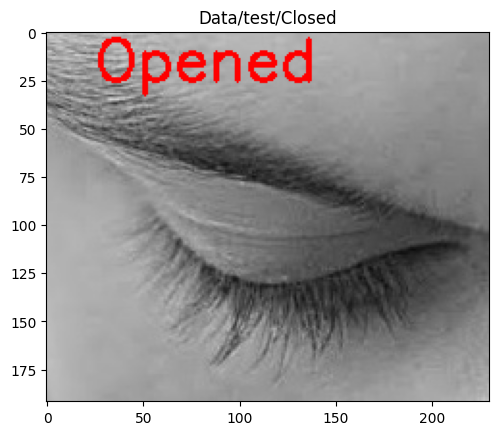

318
Data/test/Closed\_351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
319
Data/test/Closed\_352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
320
Data/test/Closed\_353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
321
Data/test/Closed\_354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
322
Data/test/Closed\_355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
323
Data/test/Closed\_356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
324
Data/test/Closed\_357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
325
Data/test/Closed\_358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
326
Data/test/Closed\_36.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
327
Data/test/Closed\_360.jpg
1/1 ━━━━━━━━━━━━━

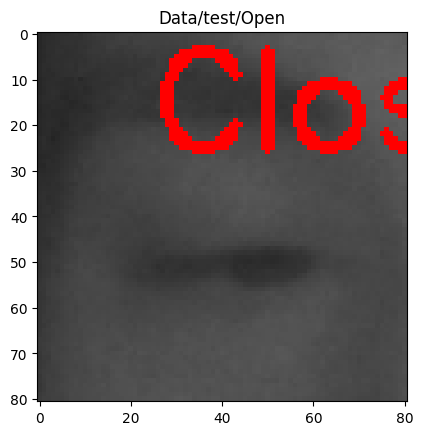

Predict Mobile : [[0.7752775  0.22472247]]  :  Closed
Default427 : [0 1] : Opened


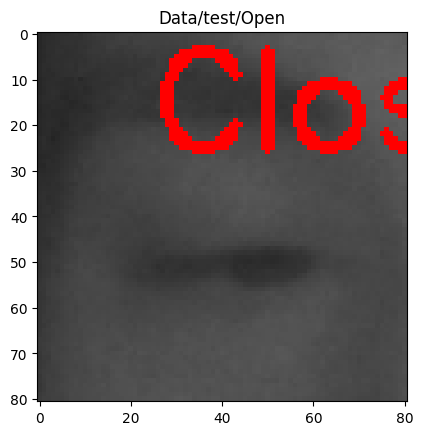

428
Data/test/Open\ex_img_24083.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predict Mobile : [[0.74318993 0.25681007]]  :  Closed
Default428 : [0 1] : Opened


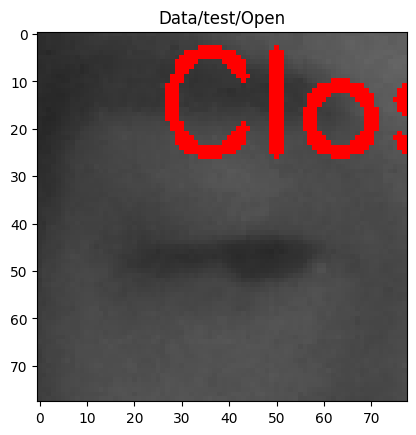

429
Data/test/Open\ex_img_24084.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
430
Data/test/Open\ex_img_24085.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predict Mobile : [[0.7261404  0.27385962]]  :  Closed
Default430 : [0 1] : Opened


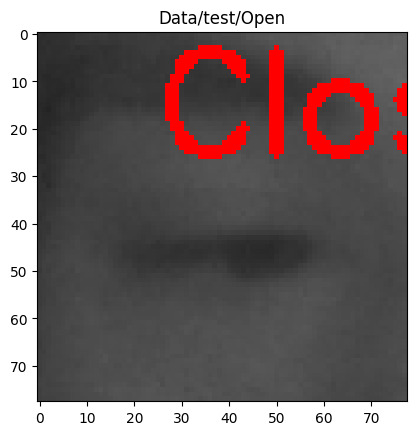

431
Data/test/Open\ex_img_24086.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predict CNN : [[0.5989426  0.40105745]]  :  Closed
Default431 : [0 1] : Opened


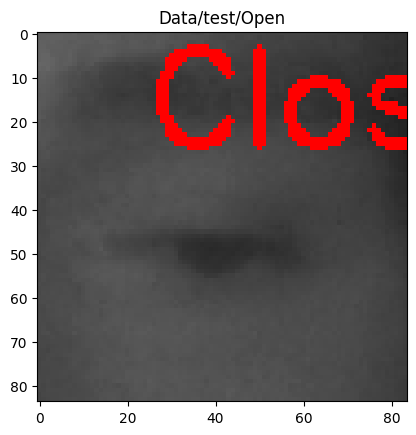

Predict Mobile : [[0.5320342 0.4679658]]  :  Closed
Default431 : [0 1] : Opened


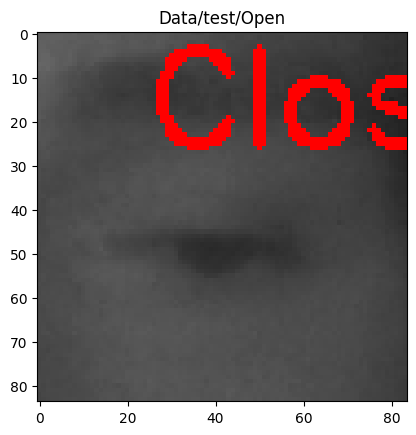

432
Data/test/Open\ex_img_24087.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
433
Data/test/Open\ex_img_24088.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predict Mobile : [[0.7197544  0.28024563]]  :  Closed
Default433 : [0 1] : Opened


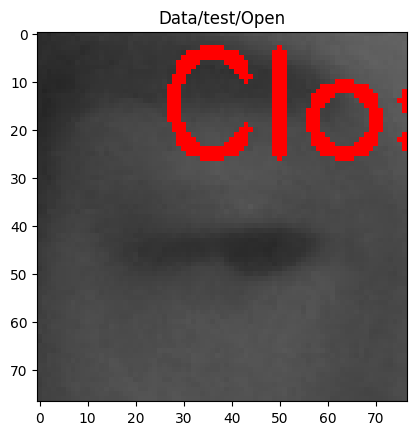

434
Data/test/Open\ex_img_24089.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predict Mobile : [[0.7078315 0.2921685]]  :  Closed
Default434 : [0 1] : Opened


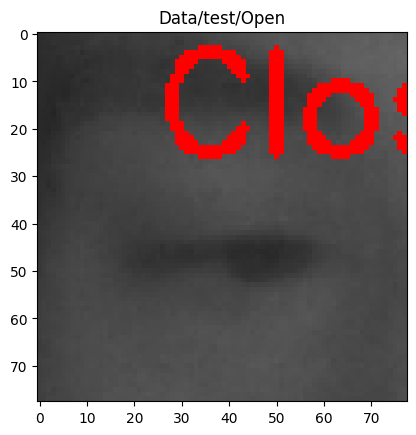

435
Data/test/Open\ex_img_24090.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predict Mobile : [[0.5039168 0.4960832]]  :  Closed
Default435 : [0 1] : Opened


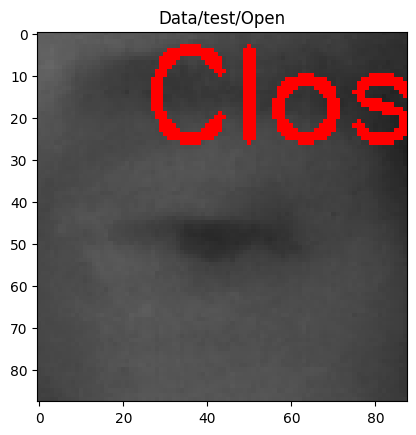

436
Data/test/Open\ex_img_24091.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
437
Data/test/Open\ex_img_24092.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predict Mobile : [[0.54948103 0.45051897]]  :  Closed
Default437 : [0 1] : Opened


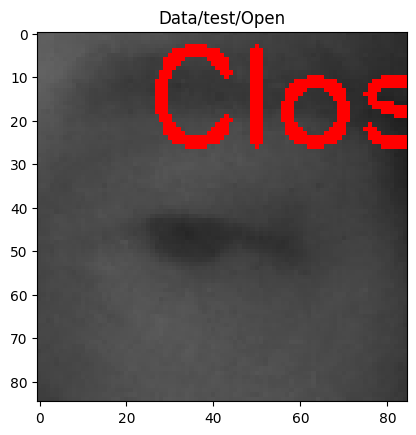

438
Data/test/Open\ex_img_24093.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
439
Data/test/Open\ex_img_24094.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
440
Data/test/Open\ex_img_24095.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
441
Data/test/Open\ex_img_24096.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
442
Data/test/Open\ex_img_24097.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predict Mobile : [[0.510251   0.48974898]]  :  Closed
Default442 : [0 1] : Opened


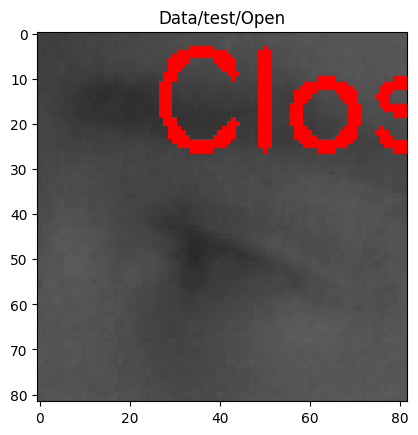

443
Data/test/Open\ex_img_24098.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
444
Data/test/Open\ex_img_24099.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predict Mobile : [[0.6955173  0.30448267]]  :  Closed
Default444 : [0 1] : Opened


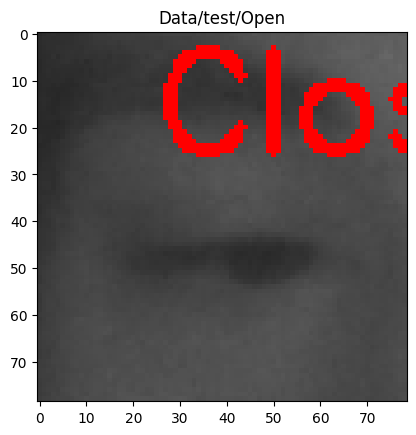

445
Data/test/Open\ex_img_24100.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
446
Data/test/Open\img_294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
447
Data/test/Open\img_295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
448
Data/test/Open\img_297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
449
Data/test/Open\img_298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
450
Data/test/Open\img_300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
451
Data/test/Open\img_301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
452
Data/test/Open\img_303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
453
Data/test/Open\img_304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
454
Data/test/Open\img_306.jpg
1

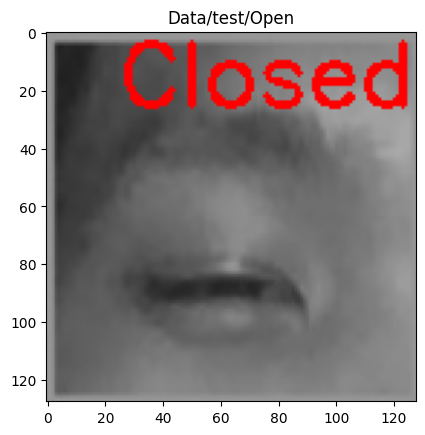

469
Data/test/Open\img_328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predict CNN : [[0.9790395  0.02096048]]  :  Closed
Default469 : [0 1] : Opened


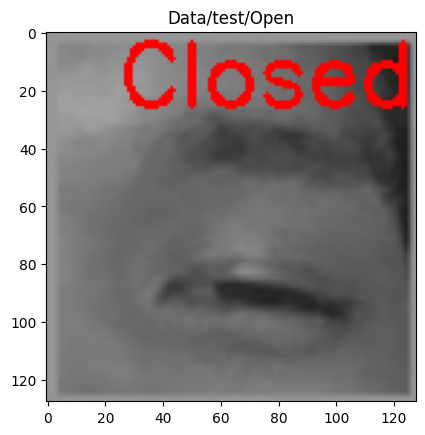

Predict Mobile : [[0.65509737 0.34490266]]  :  Closed
Default469 : [0 1] : Opened


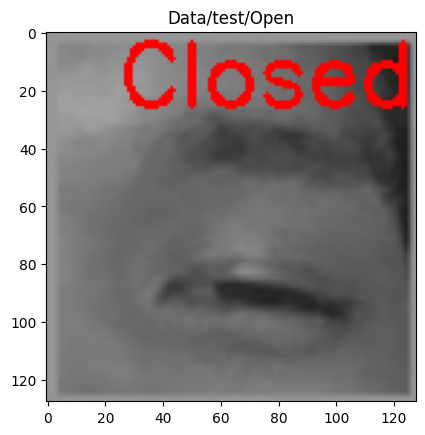

470
Data/test/Open\img_330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
471
Data/test/Open\img_331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predict Mobile : [[0.5807702 0.4192298]]  :  Closed
Default471 : [0 1] : Opened


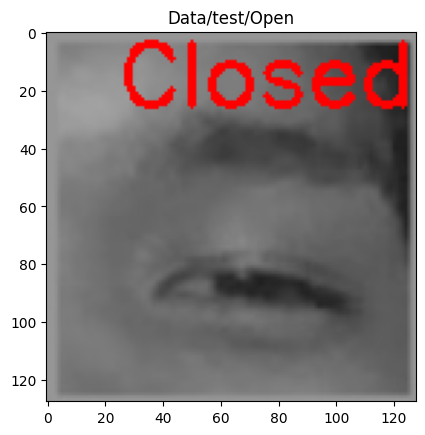

472
Data/test/Open\img_333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
473
Data/test/Open\img_334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predict Mobile : [[0.5222574 0.4777426]]  :  Closed
Default473 : [0 1] : Opened


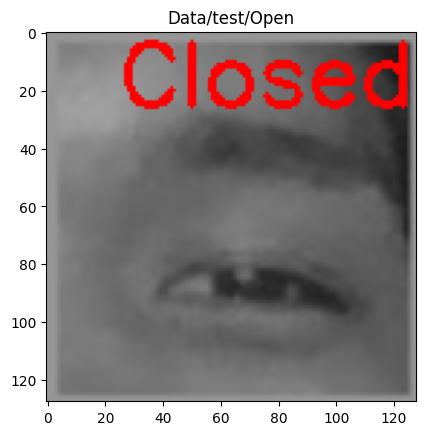

474
Data/test/Open\img_336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
475
Data/test/Open\img_337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predict Mobile : [[0.5556012  0.44439885]]  :  Closed
Default475 : [0 1] : Opened


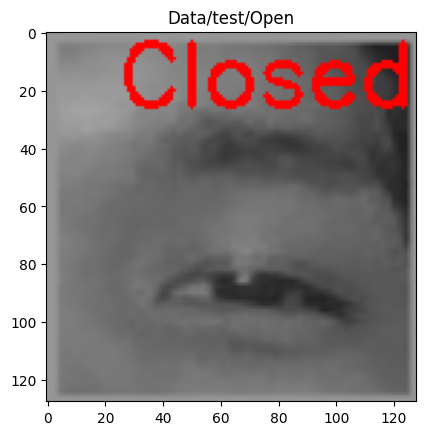

476
Data/test/Open\img_339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
477
Data/test/Open\img_340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predict Mobile : [[0.53251004 0.46749002]]  :  Closed
Default477 : [0 1] : Opened


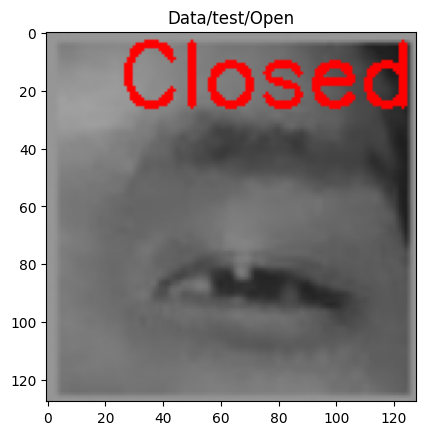

478
Data/test/Open\img_342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
479
Data/test/Open\img_343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
480
Data/test/Open\_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predict Mobile : [[0.5052957  0.49470425]]  :  Closed
Default480 : [0 1] : Opened


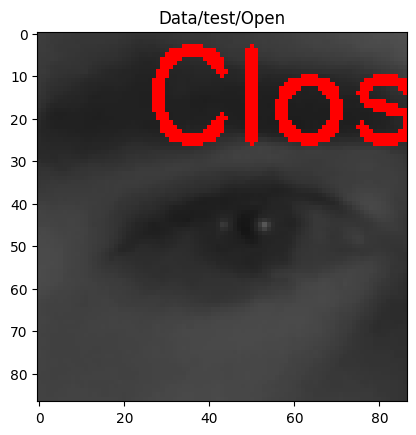

481
Data/test/Open\_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
482
Data/test/Open\_100.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
483
Data/test/Open\_101.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
484
Data/test/Open\_102.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
485
Data/test/Open\_103.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
486
Data/test/Open\_104.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
487
Data/test/Open\_105.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
488
Data/test/Open\_106.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
489
Data/test/Open\_107.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
490
Data/test/Open\_108.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

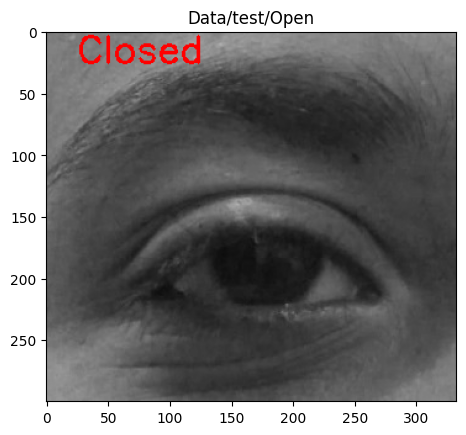

798
Data/test/Open\_389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
799
Data/test/Open\_39.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
800
Data/test/Open\_390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
801
Data/test/Open\_391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
802
Data/test/Open\_392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
803
Data/test/Open\_393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
804
Data/test/Open\_394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
805
Data/test/Open\_395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
806
Data/test/Open\_396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
807
Data/test/Open\_397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

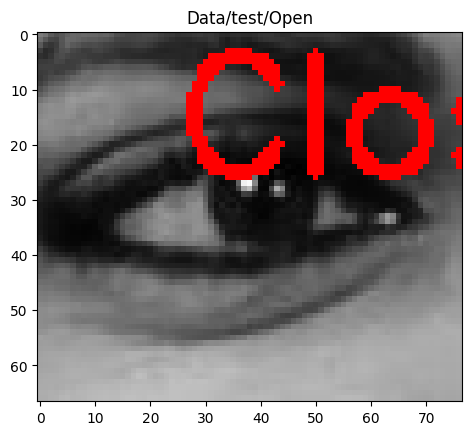

809
Data/test/Open\_399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
810
Data/test/Open\_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
811
Data/test/Open\_40.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
812
Data/test/Open\_400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
813
Data/test/Open\_401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
814
Data/test/Open\_402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
815
Data/test/Open\_403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
816
Data/test/Open\_404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predict Mobile : [[0.57209045 0.42790958]]  :  Closed
Default816 : [0 1] : Opened


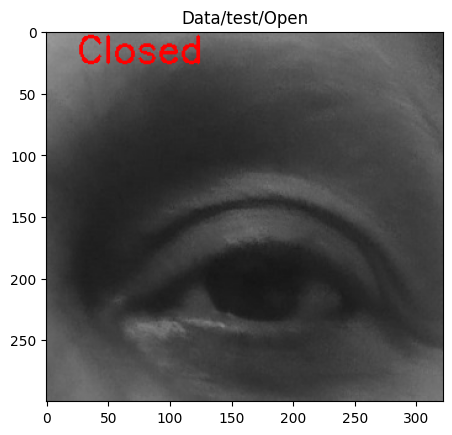

817
Data/test/Open\_405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
818
Data/test/Open\_406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predict Mobile : [[0.6577095  0.34229055]]  :  Closed
Default818 : [0 1] : Opened


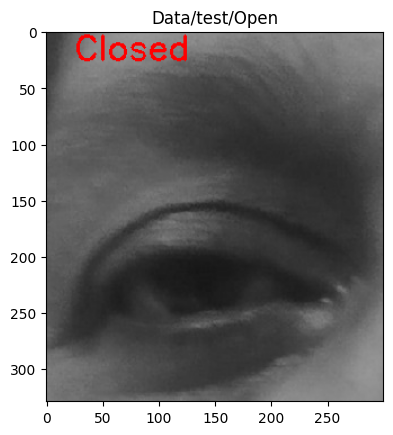

819
Data/test/Open\_407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
820
Data/test/Open\_408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
821
Data/test/Open\_409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
822
Data/test/Open\_41.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
823
Data/test/Open\_410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
824
Data/test/Open\_411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
825
Data/test/Open\_412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
826
Data/test/Open\_414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
827
Data/test/Open\_415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
828
Data/test/Open\_417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

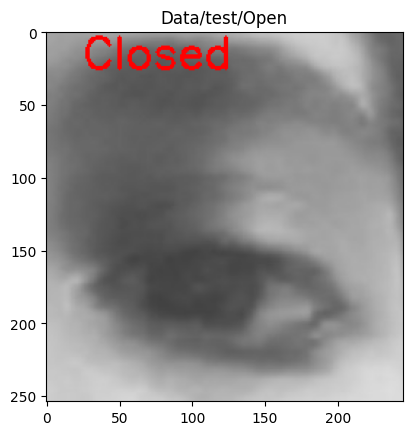

845
Data/test/Open\_432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
846
Data/test/Open\_433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
847
Data/test/Open\_435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
848
Data/test/Open\_436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
849
Data/test/Open\_437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
850
Data/test/Open\_438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
851
Data/test/Open\_44.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
852
Data/test/Open\_440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
853
Data/test/Open\_443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
854
Data/test/Open\_444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

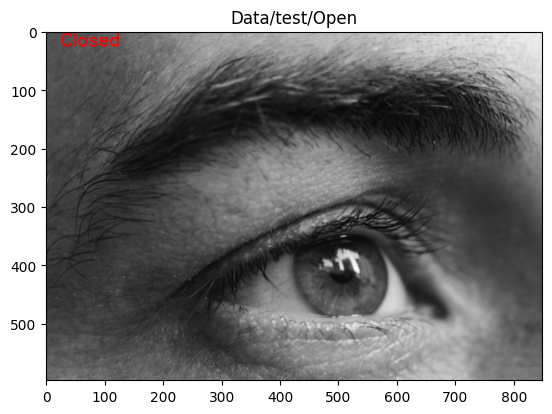

874
Data/test/Open\_464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
875
Data/test/Open\_465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
876
Data/test/Open\_466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
877
Data/test/Open\_467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
878
Data/test/Open\_468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
879
Data/test/Open\_469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
880
Data/test/Open\_47.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
881
Data/test/Open\_470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predict CNN : [[0.95472693 0.04527302]]  :  Closed
Default881 : [0 1] : Opened


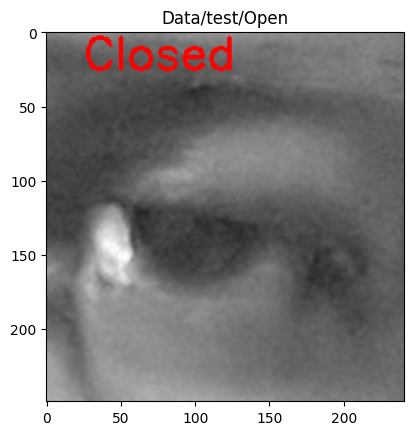

Predict Mobile : [[0.64233214 0.35766783]]  :  Closed
Default881 : [0 1] : Opened


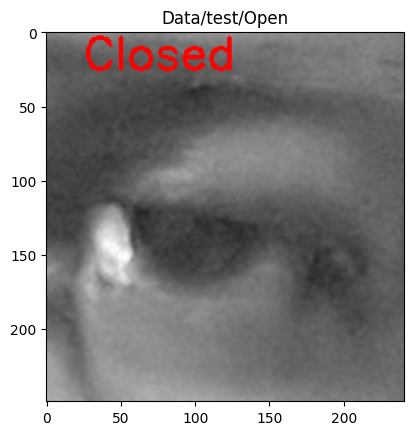

882
Data/test/Open\_471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
883
Data/test/Open\_472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
884
Data/test/Open\_473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
885
Data/test/Open\_474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
886
Data/test/Open\_475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
887
Data/test/Open\_476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
888
Data/test/Open\_477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
889
Data/test/Open\_478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
890
Data/test/Open\_479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
891
Data/test/Open\_48.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

In [ ]:
testpath = 'Data/test/'
testImg = [testpath+f for f in listdir(testpath)]
rimg = []
valid_data = 0
last_index = 0
error_model = 0
error_CNN = 0
error_mobile = 0
errorVGG = 0
n = 0
for imagePath in (testImg):
      print(imagePath)
      if imagePath == 'Data/test/Open':
            last_index = len(listdir(testpath + '/Closed'))
            print(last_index)
      for i,item in enumerate(listdir(imagePath)):
            print(last_index + i)
            file = join(imagePath, item)
            if file[-1] =='g':
                  print(file)
                  imgori = cv2.imread(file)
                  imgori =cv2.cvtColor(imgori , cv2.COLOR_BGR2GRAY)
                  imgori = cv2.cvtColor(imgori , cv2.COLOR_GRAY2BGR)
                  img = cv2.resize(imgori ,(width,width))
                  rimg = np.array(img)
                  rimg = rimg.astype('float32')
                  rimg /= 255
                  rimg = np.reshape(rimg ,(1,128,128,3))
                  predictCNN = CNNModel.predict(rimg)
                  predictMobileNet = MobileNetMOdel.predict(rimg)
                  label = ['Closed','Opened']
                  resultCNN = label[np.argmax(predictCNN)]
                  resultMobileNet = label[np.argmax(predictMobileNet)]
                  # if resultCNN != resultMobileNet:
                  #       plt.title(testImg)
                  #       cv2.putText(imgori, str(resultMobileNet), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )
                  #       print(f"Predict CNN : {resultCNN} {predictCNN}\nPredict Mobile : {resultMobileNet} {predictMobileNet}")
                  #       plt.imshow(imgori)
                  #       plt.show()
                  #       error_CNN +=1
                  #       error_mobile +=1
                  if resultCNN != label[np.argmax(y_test[(last_index + i)])] :
                        plt.title(imagePath)
                        cv2.putText(imgori, str(resultCNN), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )
                        print(f"Predict CNN : {predictCNN}  :  {resultCNN}\nDefault{last_index + i} : {y_test[(last_index + i)]} : {label[np.argmax(y_test[(last_index + i)])]}")
                        plt.imshow(imgori)
                        plt.show()
                        error_CNN +=1 
                  if resultMobileNet != label[np.argmax(y_test[(last_index + i)])] : 
                        plt.title(imagePath)
                        cv2.putText(imgori, str(resultMobileNet), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )
                        print(f"Predict Mobile : {predictMobileNet}  :  {resultMobileNet}\nDefault{last_index + i} : {y_test[(last_index + i)]} : {label[np.argmax(y_test[(last_index + i)])]}")
                        plt.imshow(imgori)
                        plt.show()
                        error_mobile +=1 

print(f"Error model : {error_model}\nError CNN : {error_CNN}\nError Mobile : {error_mobile}")


In [ ]:
testImg = 'img/Train2/Close/'
error_count = 0
for i,item in enumerate(listdir(testImg)):
      print(item)
      file = join(testImg, item)
      print(file)
      if file[-1] =='g':
            print(file)
            imgori = cv2.imread(file)
            imgori =cv2.cvtColor(imgori , cv2.COLOR_BGR2GRAY)
            imgori = cv2.cvtColor(imgori , cv2.COLOR_GRAY2BGR)
            img = cv2.resize(imgori ,(width,width))
            rimg = np.array(img)
            rimg = rimg.astype('float32')
            rimg /= 255
            rimg = np.reshape(rimg ,(1,128,128,3))
            predictModel = model.predict(rimg)
            predictCNN = CNNModel.predict(rimg)
            predictMobileNet = MobileNetMOdel.predict(rimg)
            label = ['Closed','Opened']
            resultModel = label[np.argmax(predictModel)]
            resultCNN = label[np.argmax(predictCNN)]
            resultMobileNet = label[np.argmax(predictMobileNet)]
            if resultCNN != resultMobileNet:
                  plt.title(testImg)
                  cv2.putText(imgori, str(resultMobileNet), (25,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2 )
                  print(f"Predict CNN : {resultCNN}\nPredict Mobile : {resultMobileNet}")
                  plt.imshow(imgori)
                  plt.show()
                  error_count +=1
print(f"Error : {error_count}")

In [ ]:
model.save('MobileNetV2Model.keras')

In [ ]:
base_model.save('CNNNewBaseModel.keras')